In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scdna_replication_tools.plot_utils import get_clone_cmap, get_htert_cmap

In [10]:
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True

despine_offset = 0
despine_trim = True

### Load the data and create functions for showing the relationship between S-phase enrichment of a clone at a given timepoint `t` and that clone's subsequent expansion or contraction at time `t+1` for p53 WT and p53 KO hTERT cell lines.

In [55]:
def timepoint_to_int(df):
    """Converts the timepoint column to an integer"""
    # get the timepoint column
    timepoints = df['timepoint'].values
    # convert the timepoints to integers
    timepoints = [int(x[1:]) for x in timepoints]
    # add the timepoints to the dataframe
    df['timepoint_int'] = timepoints
    # return the dataframe
    return df


def sort_timepoints(df):
    """Sort the dataframe according to clone_id and timepoint_int"""
    # if timepoint_int is not in the dataframe, create such a column
    df = timepoint_to_int(df)
    # sort the dataframe
    df = df.sort_values(by=['clone_id', 'timepoint_int'])
    # return the dataframe
    return df


def add_instantaneous_s_and_enrichment(df):
    """Adds a column to the dataframe that contains the instantaneous selection coefficient for each clone at each timepoint"""
    # compute the enrichment or depletion for S-phase cells at a given timepoint
    df['clone_frac_diff'] = df['clone_frac_s'] - df['clone_frac_g']

    times = sorted(df.timepoint_int.unique())
    clones = sorted(df.clone_id.unique())

    # this column is a proxy for that clone's instatneous selection coefficient
    df['instantaneous_s'] = np.nan

    # find difference in a clone's number/fraction of cells between two adjacent timepoints
    for t in range(len(times)-1):
        for c in clones:
            t0 = times[t]
            t1 = times[t+1]
            # find the row that corresponds to this clone & time
            row_t0 = df.loc[(df['clone_id']==c) & (df['timepoint_int']==t0)]
            row_t1 = df.loc[(df['clone_id']==c) & (df['timepoint_int']==t1)]
            # find the difference in G1/2-phase fractions between t0 and t1
            frac_diff = row_t1['clone_frac_g'].values[0] - row_t0['clone_frac_g'].values[0]

            # add frac_diff to the dataframe at the appropriate row
            df.loc[(df['clone_id']==c) & (df['timepoint_int']==t0), 'instantaneous_s'] = frac_diff
    return df


def filter_rows(df, num_cells=10):
    """Filters out rows that do not have a value for instantaneous_s or have few cells"""
    df = df.loc[df['instantaneous_s'].notna()]
    df = df.loc[df['num_cells_g'] > num_cells]
    return df

In [56]:
def spe_preprocessing(df_SA039, df_SA906a, df_SA906b):
    # analyze the SA906a data
    # sort the timepoints chronologically
    df_SA906a = sort_timepoints(df_SA906a)
    # remove SA906a timepoints that are before X25 as they are prior to CRISPR perturbation and splitting into two lines
    df_SA906a = df_SA906a.loc[df_SA906a['timepoint_int'] >= 25]
    # add the instantaneous selection coefficient and S-phase enrichment/depletion columns
    df_SA906a = add_instantaneous_s_and_enrichment(df_SA906a)
    # remove rows that do not have a value for instantaneous_s or have few cells
    df_SA906a = filter_rows(df_SA906a)

    # analyze the SA906b data
    # sort the timepoints chronologically
    df_SA906b = sort_timepoints(df_SA906b)
    # remove SA906b timepoints that are before X30 as they are prior splitting into two lines
    df_SA906b = df_SA906b.loc[df_SA906b['timepoint_int'] >= 30]
    # add the instantaneous selection coefficient and S-phase enrichment/depletion columns
    df_SA906b = add_instantaneous_s_and_enrichment(df_SA906b)
    # remove rows that do not have a value for instantaneous_s or have few cells
    df_SA906b = filter_rows(df_SA906b)

    # analyze the SA039 data
    # sort the timepoints chronologically
    df_SA039 = sort_timepoints(df_SA039)
    # add the instantaneous selection coefficient and S-phase enrichment/depletion columns
    df_SA039 = add_instantaneous_s_and_enrichment(df_SA039)
    # remove rows that do not have a value for instantaneous_s or have few cells
    df_SA039 = filter_rows(df_SA039)

    # create a new column in each dataframe that stores the sample_id
    df_SA039['sample_id'] = 'SA039'
    df_SA906a['sample_id'] = 'SA906a'
    df_SA906b['sample_id'] = 'SA906b'
    # combine the dataframes from SA039, SA906a, and SA906b
    df_combined = pd.concat([df_SA039, df_SA906a, df_SA906b])

    return df_SA039, df_SA906a, df_SA906b, df_combined

In [57]:
def plot_s_predictiveness(df, ax, title=None):
    """Plots the instantaneous selection coefficient vs. the clone's S-phase enrichment/depletion"""
    # fit a regression line to the data
    sns.regplot(y='instantaneous_s', x='clone_frac_diff', data=df, ax=ax, scatter=False, color='black')

    # create a seaborn scatterplot comparing the instantaneous selection coefficient to the clone's S-phase enrichment/depletion
    sns.scatterplot(
        y='instantaneous_s', x='clone_frac_diff', data=df, hue='clone_id', style='timepoint', 
        ax=ax, palette=get_clone_cmap(), rasterized=True
    )
     # set the y-axis label
    ax.set_ylabel('expansion score\n<-contraction | expansion->')
    # set the x-axis label
    ax.set_xlabel('SPE score\n<-S-phase depletion | enrichment->')
    # set the title
    if title is not None:
        ax.set_title(title)

    # expand the x axis limits to be slightly larger than the data
    ax.set_xlim(left=ax.get_xlim()[0] - 0.05, right=ax.get_xlim()[1] + 0.05)

    # remove the first #clone + 1 elements of the legend such that only the timepoints are shown
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles=handles[len(df.clone_id.unique())+1:], labels=labels[len(df.clone_id.unique())+1:], 
        bbox_to_anchor=(0.9, 1), loc=2, borderaxespad=0., frameon=False, ncol=1
    )

    # move the legend outside of the plot to the right
    # ax.legend(loc='upper right', borderaxespad=0., frameon=False, ncol=2)

    sns.despine(ax=ax, offset=despine_offset, trim=despine_trim)


# create a new plotting function that colors the data points by sample_id
def plot_s_predictiveness_combined(df, ax, title=None):
    """Plots the instantaneous selection coefficient vs. the clone's S-phase enrichment/depletion"""
    # fit a regression line to the data
    sns.regplot(y='instantaneous_s', x='clone_frac_diff', data=df, ax=ax, scatter=False, color='black')

    # create a seaborn scatterplot comparing the instantaneous selection coefficient to the clone's S-phase enrichment/depletion
    sns.scatterplot(
        y='instantaneous_s', x='clone_frac_diff', data=df, hue='sample_id', 
        alpha=0.5, ax=ax, palette=get_htert_cmap(), rasterized=True
    )
    # set the y-axis label
    ax.set_ylabel('expansion score\n<-contraction | expansion->')
    # set the x-axis label
    ax.set_xlabel('SPE score\n<-S-phase depletion | enrichment->')
    # set the title
    if title is not None:
        ax.set_title(title)

    # expand the x axis limits to be slightly larger than the data
    ax.set_xlim(left=ax.get_xlim()[0] - 0.05, right=ax.get_xlim()[1] + 0.05)

    # move the legend outside of the plot to the right
    ax.legend(bbox_to_anchor=(0.9, 1), loc=2, borderaxespad=0., frameon=False, ncol=1, title='sample ID')

    sns.despine(ax=ax, offset=despine_offset, trim=despine_trim)

In [58]:
def compute_clone_fracs_vs_time(df):
    """
    Computes the fraction of cells in each clone for each timepoint.
    """
    clone_frac_g_vs_time = np.zeros((len(df.clone_id.unique()), len(df.timepoint_int.unique())))
    clone_frac_s_vs_time = np.zeros((len(df.clone_id.unique()), len(df.timepoint_int.unique())))
    clone_legend = []
    timepoints = df.timepoint_int.unique()
    i = 0
    for clone_id, chunk in df.groupby('clone_id'):
        chunk.sort_values(by='timepoint_int', inplace=True)
        clone_frac_g_vs_time[i] = chunk['clone_frac_g'].values
        clone_frac_s_vs_time[i] = chunk['clone_frac_s'].values
        clone_legend.append(clone_id)
        i += 1
    return timepoints, clone_frac_g_vs_time, clone_frac_s_vs_time, clone_legend


def fill_in_missing_clones(df, clone_list=None):
    """ If there are clones present at some timepoints but not others, fill in the missing clones with 0s """
    # find the clone list if not specified
    if clone_list is None:
        clone_list = df.clone_id.unique()
    # loop through the clones and timepoints
    for clone in clone_list:
        for timepoint in df.timepoint.unique():
            # if the clone is not present at the timepoint, add a row with 0s
            if clone not in df[df.timepoint == timepoint].clone_id.values:
                new_line = pd.DataFrame({
                    'clone_id': [clone], 'timepoint': [timepoint], 'num_cells_s': [0], 'num_cells_g': [0],
                    'clone_frac_s': [0], 'clone_frac_g': [0], 'positive_p': [0], 'negative_p': [0],
                    'positive_p_adj': [0], 'negative_p_adj': [0], 'timepoint_int': [int(timepoint[1:])]
                })
                # concatenate the new line to the dataframe
                df = pd.concat([df, new_line], ignore_index=True)
    return df


def plot_clone_muller(df, dataset, ax_g, ax_s, interpolate=True, std=5, clone_cmap=get_clone_cmap()):
    """
    Plots the evolution of clones over time for each cell cycle phase. 
    """
    # sort timepoints based on the timepoint_int column
    df = sort_timepoints(df)

    # find the set of clone_ids that appear in the union of the treated and untreated samples
    clone_list = list(set(df.clone_id.unique()))
    # fill in missing clones with 0s
    df = fill_in_missing_clones(df, clone_list)

    # sort timepoints again now that we've added the earliest untreated timepoint and filled in missing clones
    df = sort_timepoints(df)

    # split the dataframe based on cell cycle and find the fraction of cells in each clone at each timepoint for each cell cycle phase
    timepoints, clone_frac_g_vs_time, clone_frac_s_vs_time, clone_legend = compute_clone_fracs_vs_time(df)
    og_timepoints = timepoints

    if interpolate:
        clone_frac_g_vs_time = pd.DataFrame(clone_frac_g_vs_time, index=clone_legend, columns=timepoints)
        clone_frac_s_vs_time = pd.DataFrame(clone_frac_s_vs_time, index=clone_legend, columns=timepoints)
            
        # add columns with NaNs for the 0.5 intervals betweeen timepoints
        for i in range(min(timepoints), max(timepoints)):
            for frac in np.linspace(0.1, 0.9, 9):
                clone_frac_g_vs_time[i + frac] = np.nan
                clone_frac_s_vs_time[i + frac] = np.nan

        # sort the columns based on timepoint
        clone_frac_g_vs_time = clone_frac_g_vs_time.reindex(sorted(clone_frac_g_vs_time.columns), axis=1)
        clone_frac_s_vs_time = clone_frac_s_vs_time.reindex(sorted(clone_frac_s_vs_time.columns), axis=1)
        timepoints = clone_frac_g_vs_time.columns

        # interpolate the NaNs
        # clone_frac_g_vs_time = clone_frac_g_vs_time.interpolate(method='spline', order=3, axis=1)
        # clone_frac_s_vs_time = clone_frac_s_vs_time.interpolate(method='spline', order=3, axis=1)
        clone_frac_g_vs_time = clone_frac_g_vs_time.T.rolling(len(timepoints), 1, True, 'gaussian').mean(std=std).T
        clone_frac_s_vs_time = clone_frac_s_vs_time.T.rolling(len(timepoints), 1, True, 'gaussian').mean(std=std).T
    
    # set x-axis ticks to all the timepoints we have measurements for
    ax_g.set_xticks(og_timepoints)
    ax_s.set_xticks(og_timepoints)

    clone_colors = [clone_cmap[x] for x in clone_legend]

    # plot as a stackplot
    baseline = 'zero'
    ax_g.stackplot(timepoints, clone_frac_g_vs_time, labels=clone_legend, baseline=baseline, colors=clone_colors)
    ax_s.stackplot(timepoints, clone_frac_s_vs_time, labels=clone_legend, baseline=baseline, colors=clone_colors)
    ax_g.set_ylabel('clone fraction')
    ax_s.set_ylabel('clone fraction')
    ax_g.set_xlabel('timepoint')
    ax_s.set_xlabel('timepoint')
    ax_g.set_title('{}: G1/2-phase'.format(dataset))
    ax_s.set_title('{}: S-phase'.format(dataset))
    # add a legend and move it to the left of the y-axis label
    ax_s.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False, title='clone ID', ncol=2)
    # set the x-axis limits to be the very first and last timepoints
    ax_s.set_xlim(min(timepoints), max(timepoints))
    ax_g.set_xlim(min(timepoints), max(timepoints))
    sns.despine(ax=ax_g, offset=0, trim=despine_trim)
    sns.despine(ax=ax_s, offset=0, trim=despine_trim)

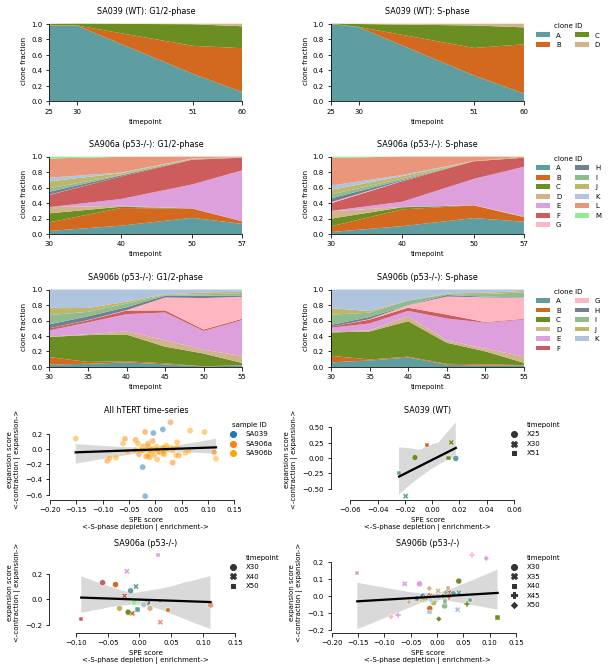

In [62]:
fig, ax = plt.subplots(6, 2, figsize=(8.5, 11), tight_layout=True)

# read in the data
df_SA039 = pd.read_csv('scdna_replication_paper/analysis/fitness_lines/SA039/cell_cycle_clone_counts.tsv', sep='\t')
df_SA906a = pd.read_csv('scdna_replication_paper/analysis/fitness_lines/SA906a/cell_cycle_clone_counts.tsv', sep='\t')
df_SA906b = pd.read_csv('scdna_replication_paper/analysis/fitness_lines/SA906b/cell_cycle_clone_counts.tsv', sep='\t')

# sort the timepoints chronologically
df_SA906a = sort_timepoints(df_SA906a)
# remove SA906a timepoints that are before X25 as they are prior to CRISPR perturbation and splitting into two lines
df_SA906a = df_SA906a.loc[df_SA906a['timepoint_int'] >= 25]
# sort the timepoints chronologically
df_SA906b = sort_timepoints(df_SA906b)
# remove SA906b timepoints that are before X30 as they are prior splitting into two lines
df_SA906b = df_SA906b.loc[df_SA906b['timepoint_int'] >= 30]

# plot the muller plots for the SA039 data in the 2nd row
plot_clone_muller(df_SA039, 'SA039 (WT)', ax[1, 0], ax[1, 1], interpolate=False)

# plot the muller plots for the SA906a data in the 3rd row
plot_clone_muller(df_SA906a, 'SA906a (p53-/-)', ax[2, 0], ax[2, 1], interpolate=False)

# plot the muller plots for the SA906b data in the 4th row
plot_clone_muller(df_SA906b, 'SA906b (p53-/-)', ax[3, 0], ax[3, 1], interpolate=False)

# preprocess the data for s predictiveness plots
df_SA039, df_SA906a, df_SA906b, df_combined = spe_preprocessing(df_SA039, df_SA906a, df_SA906b)

# plot the combined data in the top left subplot
plot_s_predictiveness_combined(df_combined, ax=ax[4, 0], title='All hTERT time-series')
# plot the SA039 data in the top right subplot
plot_s_predictiveness(df_SA039, ax=ax[4, 1], title='SA039 (WT)')
# plot the SA906a data in the bottom left subplot
plot_s_predictiveness(df_SA906a, ax=ax[5, 0], title='SA906a (p53-/-)')
# plot the SA906b data in the bottom right subplot
plot_s_predictiveness(df_SA906b, ax=ax[5, 1], title='SA906b (p53-/-)')

# set the subplots in the top row to be invisible
ax[0, 0].set_visible(False)
ax[0, 1].set_visible(False)

fig.savefig('scdna_replication_paper/manuscript/supplementary_figs/figS5.pdf', dpi=300, bbox_inches='tight')

plt.show()